In [2]:
import random
import os
import sys
import collections

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mxnet as mx
from matplotlib import style
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from bert_embedding import BertEmbedding

In [4]:
sys.path.append('../detector/')

In [5]:
style.use('ggplot')

In [6]:
from corpora import Corpora

c:\users\eemeli\documents\projects\keytopicdetection\.env\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [7]:
data_path = 'M:/Projects/KeyTopicDetection/parsed'
dict_path = '../data/cvpr_13-18_DICT.txt'

In [8]:
if os.path.exists(dict_path):
    corpora = Corpora(data_path=data_path, prefix='CVPR', iterator='bow', dictionary=dict_path)
else:
    corpora = Corpora(data_path=data_path, prefix='CVPR', iterator='bow', word_up_limit=0.75, word_low_limit=20).build()
    corpora.dictionary.save_as_text(dict_path)

In [9]:
%time ctx = mx.gpu(0)

Wall time: 0 ns


In [10]:
%time bert = BertEmbedding(ctx=ctx)

c:\users\eemeli\documents\projects\keytopicdetection\.env\lib\site-packages\gluonnlp\model\block.py:113: UserWarning: `erf` operator support is not found. Please consider upgrading to mxnet >= 1.4
  warnings.warn('`erf` operator support is not found. '


Wall time: 4.43 s


In [10]:
top_tokens = sorted(corpora.dictionary.dfs, key=lambda k: corpora.dictionary.dfs[k], reverse=True)[:20]

In [48]:
corpora.dictionary.dfs[top_tokens[0]]

3012

In [11]:
interesting_words = [corpora.dictionary[t] for t in top_tokens]

In [12]:
interesting_words

['applications',
 'real',
 'applied',
 'vector',
 'recent',
 'pattern',
 'linear',
 'low',
 'datasets',
 'local',
 'process',
 'previous',
 'directly',
 'obtain',
 'task',
 'detection',
 'processing',
 'perform',
 'mean',
 'wang']

In [13]:
target_word = 'recent'

In [14]:
sentences = []
for i, s in enumerate(corpora.sentences()):
    if i % 500 == 0:
        print(i)
    for ss in s:
        if target_word in ss:
            sentences.append(ss)

0


500
1000


1500


2000


2500
3000


3500


In [15]:
len(sentences)

9843

In [16]:
N = len(sentences)

In [17]:
#{word:[] for word in interesting_words}

In [18]:
batch = []
for i, sentence in enumerate(sentences):
    batch.append(sentence)
    if i == N - 1:
        pass
    elif len(batch) < 100:
        continue

    %time result = bert.embedding(batch)
    if i % 50 == 0:
        print(i)
    for s in result:
        for i, word in enumerate(s[1]):
            if word == target_word:
                vectors.append(s[2][i])
    batch = []

Wall time: 460 ms
Wall time: 390 ms
Wall time: 385 ms
Wall time: 381 ms
Wall time: 381 ms
Wall time: 376 ms
Wall time: 385 ms
Wall time: 377 ms
Wall time: 376 ms
Wall time: 399 ms
Wall time: 375 ms
Wall time: 389 ms
Wall time: 385 ms
Wall time: 379 ms
Wall time: 371 ms
Wall time: 375 ms
Wall time: 381 ms
Wall time: 378 ms
Wall time: 380 ms
Wall time: 393 ms
Wall time: 376 ms
Wall time: 381 ms
Wall time: 378 ms
Wall time: 394 ms
Wall time: 398 ms
Wall time: 393 ms
Wall time: 380 ms
Wall time: 376 ms
Wall time: 379 ms
Wall time: 381 ms
Wall time: 382 ms
Wall time: 381 ms
Wall time: 381 ms
Wall time: 381 ms
Wall time: 385 ms
Wall time: 376 ms
Wall time: 376 ms
Wall time: 381 ms
Wall time: 377 ms
Wall time: 383 ms
Wall time: 386 ms
Wall time: 382 ms
Wall time: 386 ms
Wall time: 390 ms
Wall time: 385 ms
Wall time: 378 ms
Wall time: 382 ms
Wall time: 381 ms
Wall time: 379 ms
Wall time: 386 ms
Wall time: 384 ms
Wall time: 382 ms
Wall time: 379 ms
Wall time: 380 ms
Wall time: 393 ms
Wall time:

In [19]:
target_matrix = np.stack(vectors)

In [21]:
pca = PCA(n_components=2)

In [22]:
%time reduced = pca.fit_transform(target_matrix)

Wall time: 157 ms


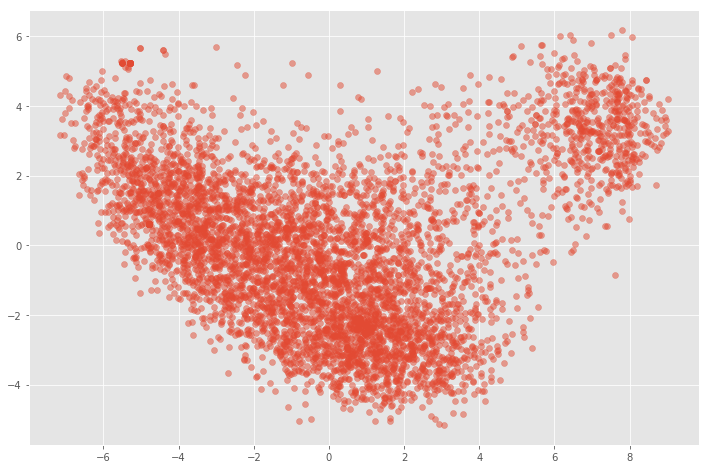

In [23]:
plt.figure(figsize=(12,8))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.5)

In [25]:
%time db = DBSCAN(eps=0.5, min_samples=50).fit(reduced)

Wall time: 69 ms


In [26]:
samples_mask = np.zeros_like(db.labels_, dtype=bool)
samples_mask[db.core_sample_indices_] = True
labels = db.labels_

In [27]:
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
%time n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

Wall time: 999 µs


2

In [29]:
unique_labels = set(labels)
unique_labels

{-1, 0, 1}

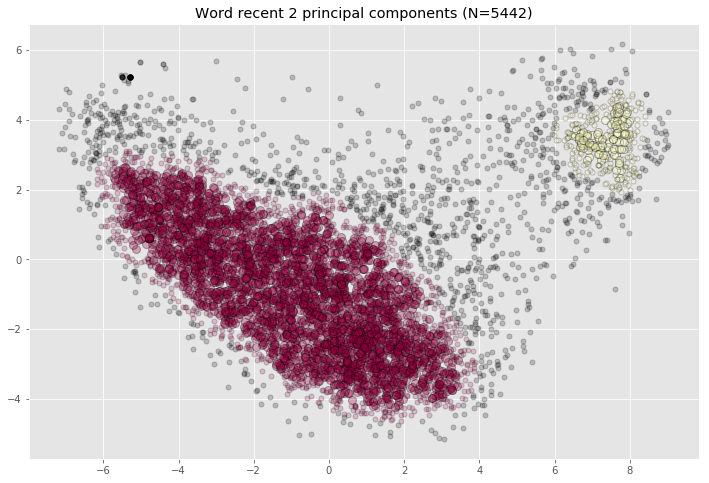

In [30]:
plt.figure(figsize=(12,8))
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = reduced[class_member_mask & samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=8, alpha=0.3)

    xy = reduced[class_member_mask & ~samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=5, alpha=0.2)
plt.title(f'Word {target_word} 2 principal components (N={target_matrix.shape[0]})')
plt.savefig(f'{target_word}_{n_clusters_}c_{target_matrix.shape[0]}N.png')
plt.show()

In [31]:
for label in unique_labels:
    print(f'Cluster label: {label}')
    print('-----------------')
    indices = np.argwhere(labels == label)
    print(len(indices))
    for idx in random.sample(indices.tolist(), 5):
        print(sentences[idx[0]])
    print()

Cluster label: 0
-----------------
3911
Inspired by the recent success of random decision forests for edge detection [16, 9], we train a random forest classifier to learn a mapping from patches to this label set.
A number of recent studies [41, 43] suggest that high level visual semantics (such as motif, parts, or objects) are appearing in the middle of deep architecture which in turn provide strong cues to recognize complex visual concepts.
As we highlighted in the previous section, automating 3D mesh segmentation has been an area of recent interest.
These energies are optimized using gradient descent, but more recently methods of convex relaxations have improved results in many cases [7, 5, 34].
This paper builds on recent ideas in the areas of computer vision (for numerically representing facial appearance as features) and social psychology (for investigating the social impact of ﬁrst names).

Cluster label: 1
-----------------
301
Large-scale labeled image datasets have had a trans

In [11]:
def visualize_clusters(tw, data):
    db = DBSCAN(eps=0.5, min_samples=50).fit(data)
    samples_mask = np.zeros_like(db.labels_, dtype=bool)
    samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
    unique_labels = set(labels)
    plt.figure(figsize=(12,8))
    colors = [plt.cm.Spectral(each)
              for each in np.linspace(0, 1, len(unique_labels))]
    for k, col in zip(unique_labels, colors):
        if k == -1:
            col = [0, 0, 0, 1]

        class_member_mask = (labels == k)

        xy = data[class_member_mask & samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=8, alpha=0.3)

        xy = data[class_member_mask & ~samples_mask]
        plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                 markeredgecolor='k', markersize=5, alpha=0.2)
    plt.title(f'Word {tw} 2 principal components (N={data.shape[0]})')
    plt.savefig(f'{tw}_{n_clusters_}c_{data.shape[0]}N.png')
    plt.show()

In [12]:
def word_clusters(tw):
    my_sentences = []
    for i, s in enumerate(corpora.sentences()):
        for ss in s:
            if tw in ss:
                my_sentences.append(ss)
    N = len(my_sentences)
    vectors = []
    batch = []
    for i, sentence in enumerate(my_sentences):
        batch.append(sentence)
        if i == N - 1:
            pass
        elif len(batch) < 100:
            continue

        result = bert.embedding(batch)
        for s in result:
            for i, word in enumerate(s[1]):
                if word == tw:
                    vectors.append(s[2][i])
        batch = []
    target_matrix = np.stack(vectors)
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(target_matrix)

    visualize_clusters(tw, reduced)

In [13]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

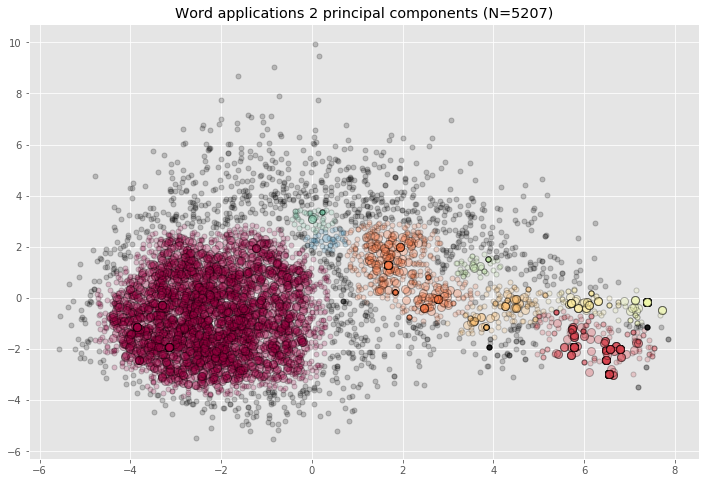

Wall time: 1min 59s


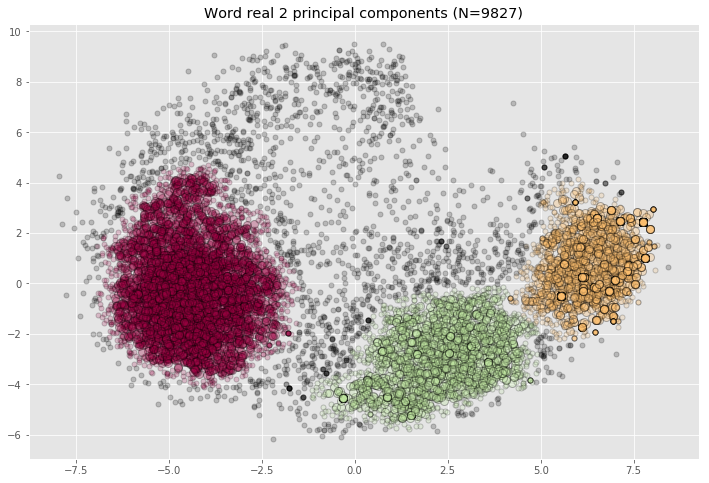

Wall time: 2min 44s


In [ ]:
for token in sorted(corpora.dictionary.dfs, key=lambda k: corpora.dictionary.dfs[k], reverse=True):
    word = corpora.dictionary[token]
    if corpora.dictionary.dfs[token] < 1000:
        break
    %time word_clusters(word)

## Discussion

The process is heavy and might scale up to absurd number of observation features for each word thus online versions could be utilized for effectively utilize the token level features for word embeddings.

- Test the LDA for the clustered sentences to get the cluster specific topics.